In [1072]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1073]:
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from prettytable import PrettyTable
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

In [1074]:
%cd '/content/drive/MyDrive/Politecnico/Mathematics for Machine Learning/Regression tutorial'

/content/drive/MyDrive/Politecnico/Mathematics for Machine Learning/Regression tutorial


### Import dataset

In [1075]:
d_types = {'date':str, 'quarter':str, 'department':str, 'day':str, 'team':int,
           'targeted_productivity':float, 'smv':float, 'wip':float, 'over_time':int,
           'incentive':int, 'idle_time':float, 'idle_men':int, 'no_of_style_change':int,
           'no_of_workers':float, 'actual_productivity':float}

df = pd.read_csv("garments_worker_productivity.csv", sep=',', dtype=d_types)
df = df.drop(columns='date')
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [1076]:
df.department.unique()
df['department'] = df['department'].astype('str').apply(lambda x: x.strip())
df.department.unique()

array(['sweing', 'finishing'], dtype=object)

In [1077]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 131.0+ 

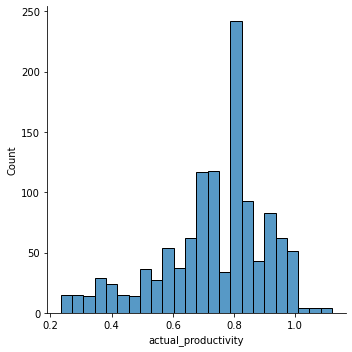

In [1078]:
sns.displot(df, x="actual_productivity")
df['actual_productivity_exp'] = np.exp(df.actual_productivity+1)

#### Training, validation and Test

In [1079]:
from sklearn.model_selection import train_test_split
X = df.loc[:,df.columns != 'actual_productivity']
y = df.loc[:,df.columns == 'actual_productivity']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=17, test_size=0.30)
# test set must not be touched
df_train_val = pd.concat([X_train_val, y_train_val], axis=1)
df_train_val

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity_exp,actual_productivity
524,Quarter5,finishing,Saturday,1,0.75,3.94,NaN,1800,0,0.0,0,0,15.0,7.184074,0.971867
838,Quarter3,finishing,Wednesday,8,0.70,5.13,NaN,960,0,0.0,0,0,8.0,4.854956,0.580000
655,Quarter2,sweing,Sunday,2,0.80,22.52,1233.0,6900,113,0.0,0,0,57.5,7.389193,1.000019
136,Quarter2,sweing,Thursday,2,0.80,28.08,783.0,10050,63,0.0,0,0,58.5,6.052656,0.800497
35,Quarter1,finishing,Saturday,10,0.70,4.15,NaN,960,0,0.0,0,0,8.0,5.483878,0.701812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Quarter3,finishing,Saturday,5,0.65,4.15,NaN,2700,0,0.0,0,0,15.0,7.295057,0.987197
752,Quarter2,finishing,Saturday,12,0.80,4.08,NaN,1080,0,0.0,0,0,9.0,6.055027,0.800889
406,Quarter4,sweing,Saturday,12,0.75,15.26,1316.0,6120,40,0.0,0,0,34.0,5.755059,0.750079
143,Quarter2,finishing,Thursday,3,0.75,4.15,NaN,2160,0,0.0,0,0,12.0,5.543501,0.712626


### targeted_productivity - Actual productivity

Text(0, 0.5, 'Targeted productivity')

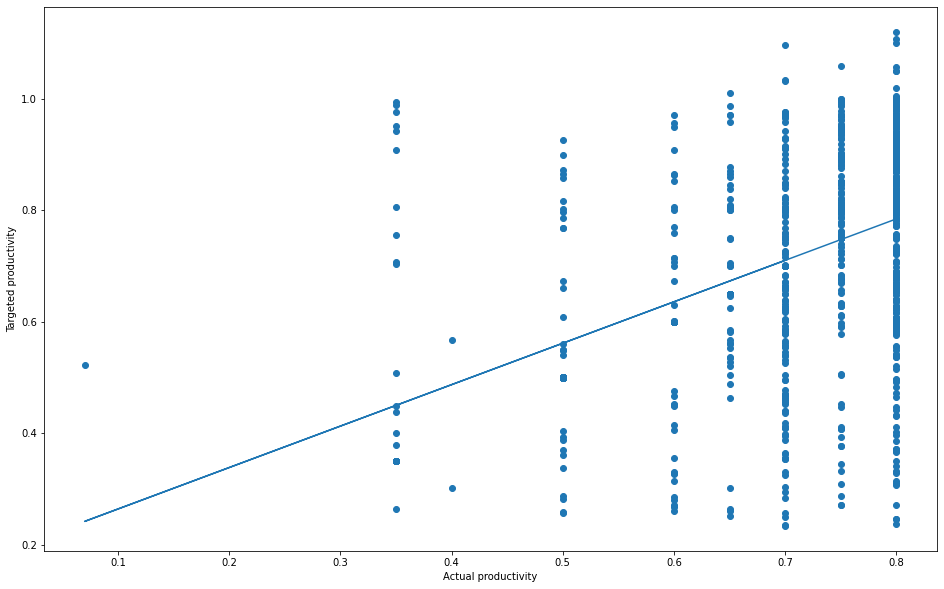

In [1080]:
model = ols("actual_productivity~targeted_productivity", data=df_train_val) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.targeted_productivity , b0 + b1*df.targeted_productivity )
plt.scatter(df.targeted_productivity, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Targeted productivity")

In [1081]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.168
Model:                             OLS   Adj. R-squared:                  0.167
Method:                  Least Squares   F-statistic:                     168.6
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           3.00e-35
Time:                         12:50:59   Log-Likelihood:                 347.62
No. Observations:                  837   AIC:                            -691.2
Df Residuals:                      835   BIC:                            -681.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [1082]:
dir(fit)
fit.pvalues
# The targeted productivity is strongly correlated to the actual productivity,
# in fact the explained variance is the 17.8% and
# The p-value is really small. 
# Given an increase of 1 of the targeted productivity the actual productivity on average increase of 0.75.

Intercept                7.262069e-06
targeted_productivity    3.000781e-35
dtype: float64

### smv - Actual productivity

Text(0, 0.5, 'Standard minute value')

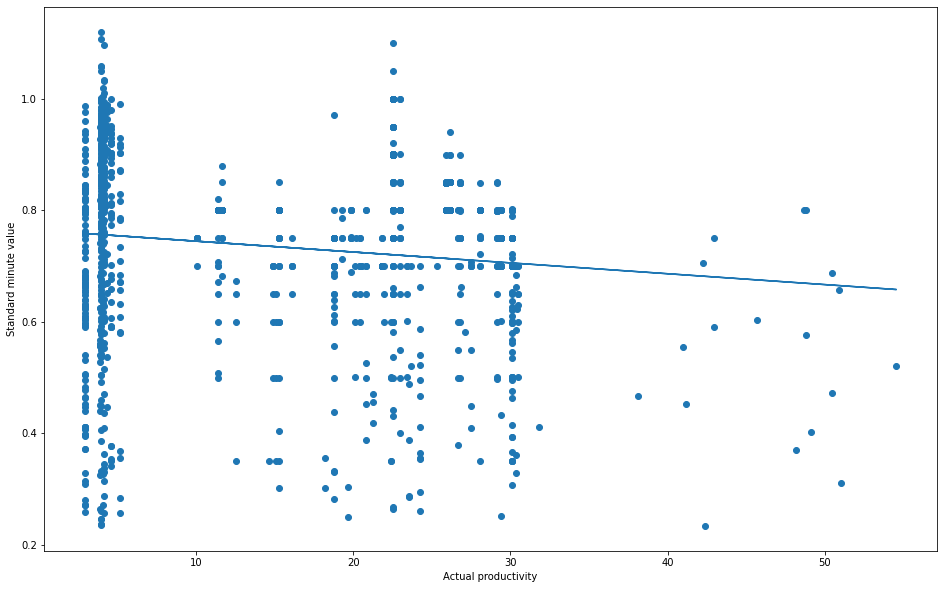

In [1083]:
model = ols("actual_productivity~smv", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.smv , b0 + b1*df.smv )
plt.scatter(df.smv, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Standard minute value")

In [1084]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.014
Method:                  Least Squares   F-statistic:                     18.08
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           2.28e-05
Time:                         12:50:59   Log-Likelihood:                 400.86
No. Observations:                 1197   AIC:                            -797.7
Df Residuals:                     1195   BIC:                            -787.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7644      0.009     89.69

In [1085]:
dir(fit)
fit.pvalues
# The smv is not strongly correlated to the actual productivity, the explained variance is around 0.01.
# However the p-value is not so high, so we should continue to consider this predictors.

Intercept    0.000000
smv          0.000023
dtype: float64

### wip - actual productivity

Text(0, 0.5, 'Work in progress')

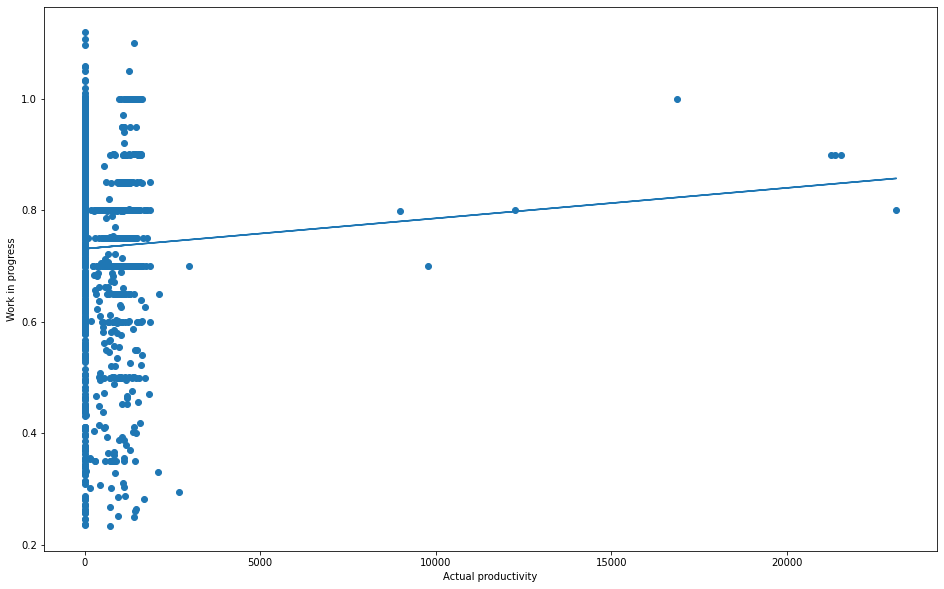

In [1086]:
wip_null_mask = df['wip'].isnull()
df.loc[wip_null_mask, 'wip'] = df.loc[wip_null_mask, 'wip'].fillna(0)

model = ols("actual_productivity~wip", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.wip , b0 + b1*df.wip )
plt.scatter(df.wip, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Work in progress")

In [1087]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     2.690
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):              0.101
Time:                         12:51:00   Log-Likelihood:                 393.22
No. Observations:                 1197   AIC:                            -782.4
Df Residuals:                     1195   BIC:                            -772.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7313      0.006    132.13

In [1088]:
dir(fit)
fit.pvalues
# The p-value is really high, so we cannot reject the hypothesis of the f-statistic such that the coefficient is zero.
# The explained variance is 0.02%, so this predictor should not be considered.

Intercept    0.000000
wip          0.101265
dtype: float64

### over_time - actual productivity

Text(0, 0.5, 'Over time')

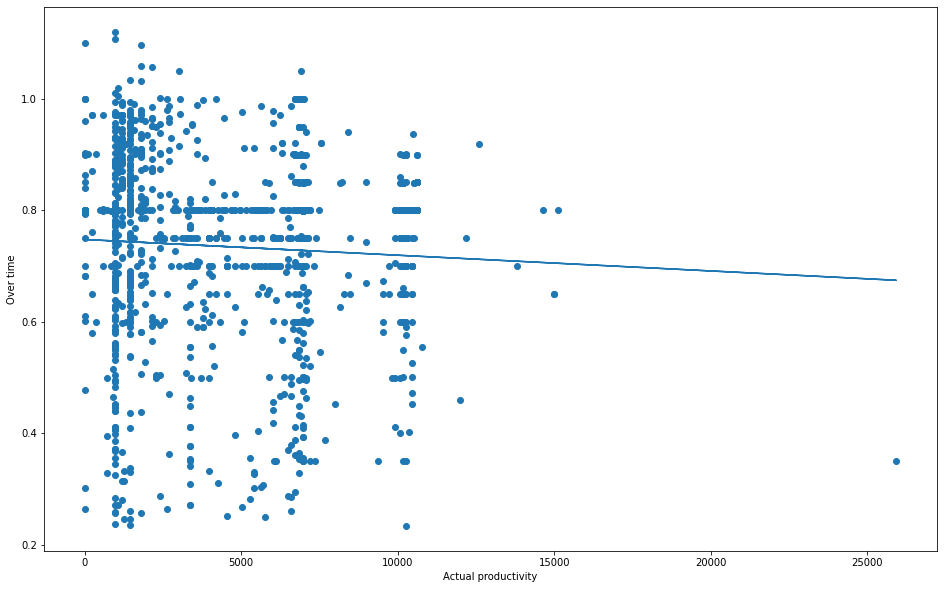

In [1089]:
model = ols("actual_productivity~over_time", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.over_time , b0 + b1*df.over_time )
plt.scatter(df.over_time, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Over time")

In [1090]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     3.522
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):             0.0608
Time:                         12:51:00   Log-Likelihood:                 393.63
No. Observations:                 1197   AIC:                            -783.3
Df Residuals:                     1195   BIC:                            -773.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7480      0.009     87.76

In [1091]:
dir(fit)
fit.pvalues
# Also in this case the p-value is quite high, 
# so the coefficient of this predictor is very close to zero and it is not relevant.

Intercept    0.000000
over_time    0.060818
dtype: float64

### incentive - actual productivity

Text(0, 0.5, 'Incentive')

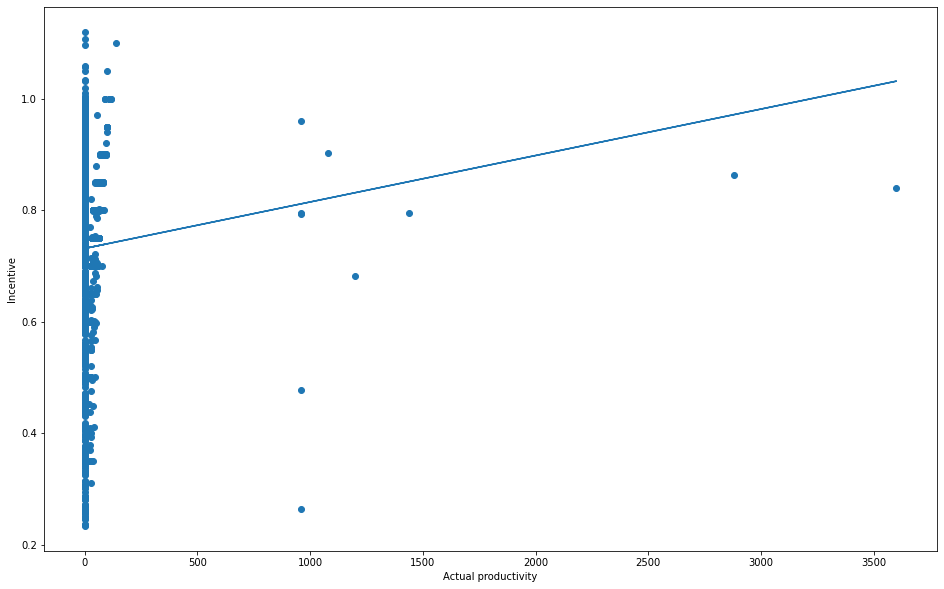

In [1092]:
model = ols("actual_productivity~incentive", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.incentive , b0 + b1*df.incentive )
plt.scatter(df.incentive, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Incentive")

In [1093]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     7.042
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):            0.00807
Time:                         12:51:00   Log-Likelihood:                 395.39
No. Observations:                 1197   AIC:                            -786.8
Df Residuals:                     1195   BIC:                            -776.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7319      0.005    141.51

In [1094]:
dir(fit)
fit.pvalues
# The coefficent is very close to zero and the explained variance is only the 0.06%, 
# however the p-value also is quite small, it is more intuitive to keep this predictor in the further analysis.

Intercept    0.00000
incentive    0.00807
dtype: float64

### idle_time - actual productivity

Text(0, 0.5, 'idle time')

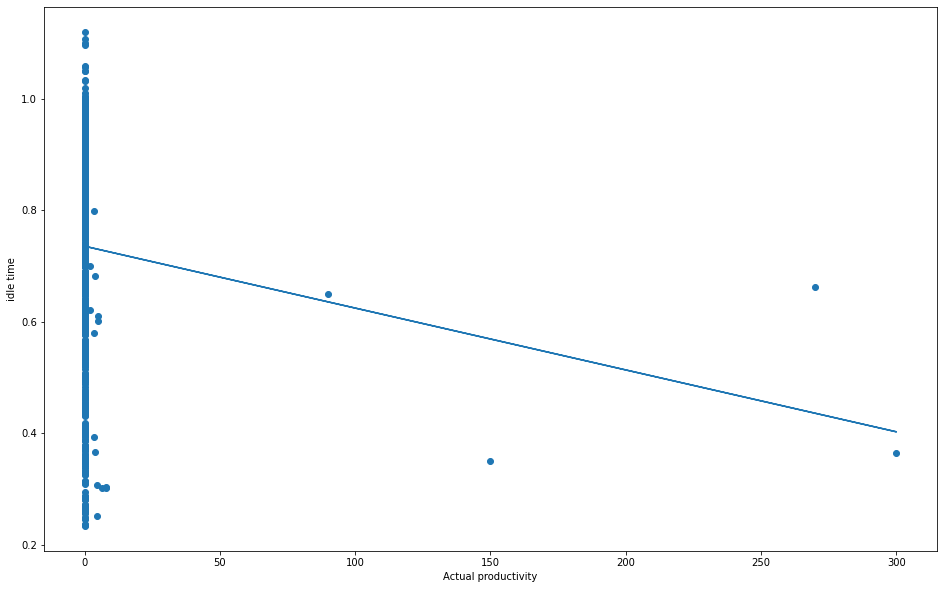

In [1095]:
model = ols("actual_productivity~idle_time", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.idle_time , b0 + b1*df.idle_time)
plt.scatter(df.idle_time, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("idle time")

In [1096]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     7.863
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):            0.00513
Time:                         12:51:01   Log-Likelihood:                 395.80
No. Observations:                 1197   AIC:                            -787.6
Df Residuals:                     1195   BIC:                            -777.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7359      0.005    146.09

In [1097]:
dir(fit)
fit.pvalues
# The coefficient related to idle time is very close to zero, the p-value is small (0.005), the explained variable is 0.6%

Intercept    0.000000
idle_time    0.005128
dtype: float64

### idle_men - actual productivity

Text(0, 0.5, 'idle men')

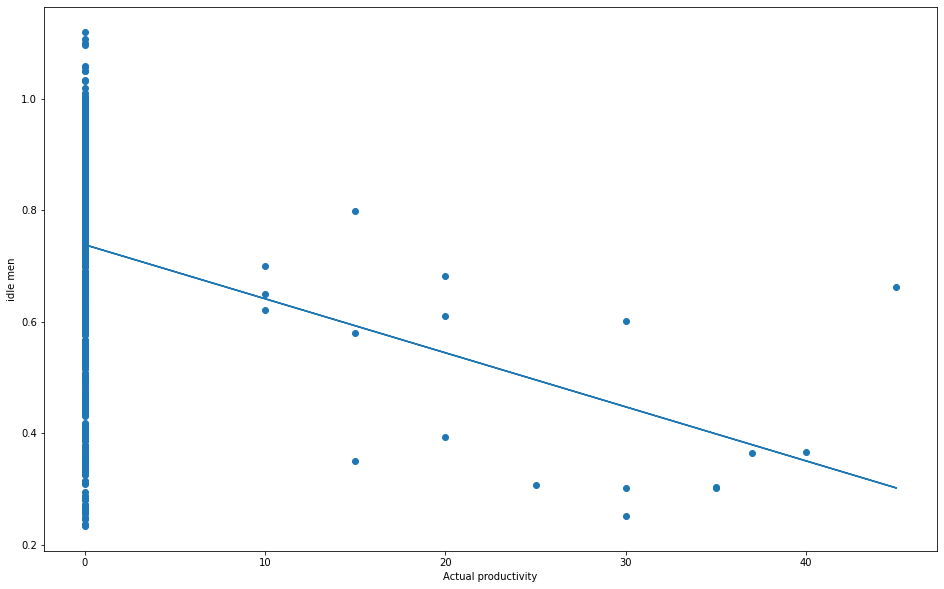

In [1098]:
model = ols("actual_productivity~idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.idle_men , b0 + b1*df.idle_men)
plt.scatter(df.idle_men, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("idle men")

In [1099]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     40.82
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           2.39e-10
Time:                         12:51:01   Log-Likelihood:                 411.97
No. Observations:                 1197   AIC:                            -819.9
Df Residuals:                     1195   BIC:                            -809.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7387      0.005    147.94

In [1100]:
dir(fit)
fit.pvalues
# Idle men has a very small p-value and an explained variance of 3%, so we should take it into account

Intercept    0.000000e+00
idle_men     2.391453e-10
dtype: float64

### no_of_style_change - actual productivity

Text(0, 0.5, 'no_of_style_change')

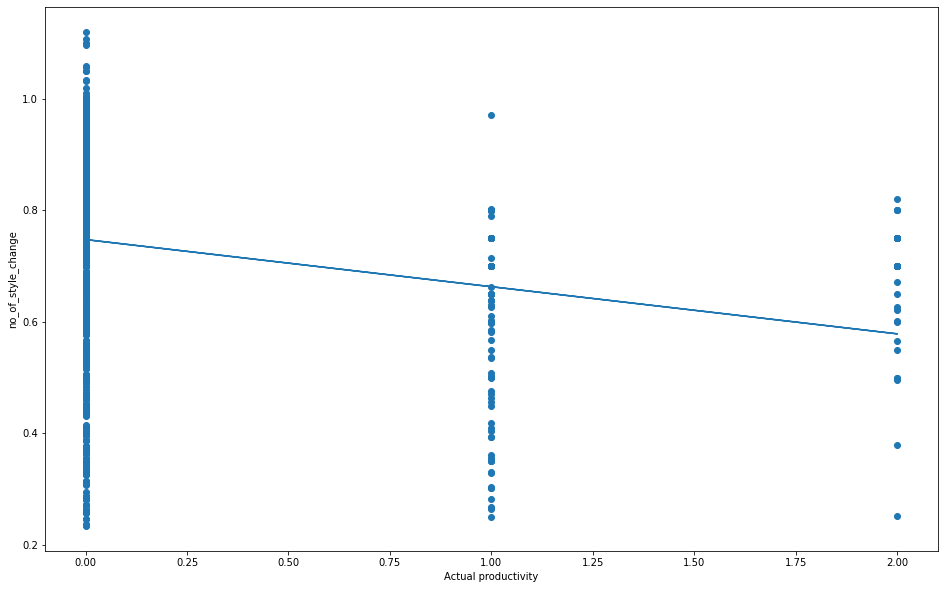

In [1101]:
model = ols("actual_productivity~no_of_style_change", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.no_of_style_change , b0 + b1*df.no_of_style_change)
plt.scatter(df.no_of_style_change, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("no_of_style_change")

In [1102]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.043
Model:                             OLS   Adj. R-squared:                  0.042
Method:                  Least Squares   F-statistic:                     53.69
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           4.30e-13
Time:                         12:51:01   Log-Likelihood:                 418.18
No. Observations:                 1197   AIC:                            -832.4
Df Residuals:                     1195   BIC:                            -822.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7

In [1103]:
dir(fit)
fit.pvalues
# The number of style change has a very small p-value and an explained variance of 4%, 
# so we need to take it into consideration.
# For an increase of 1 of the number of style change the average productivity decreases of 0.08.

Intercept             0.000000e+00
no_of_style_change    4.299784e-13
dtype: float64

### no_of_workers - actual productivity

Text(0, 0.5, 'no_of_workers')

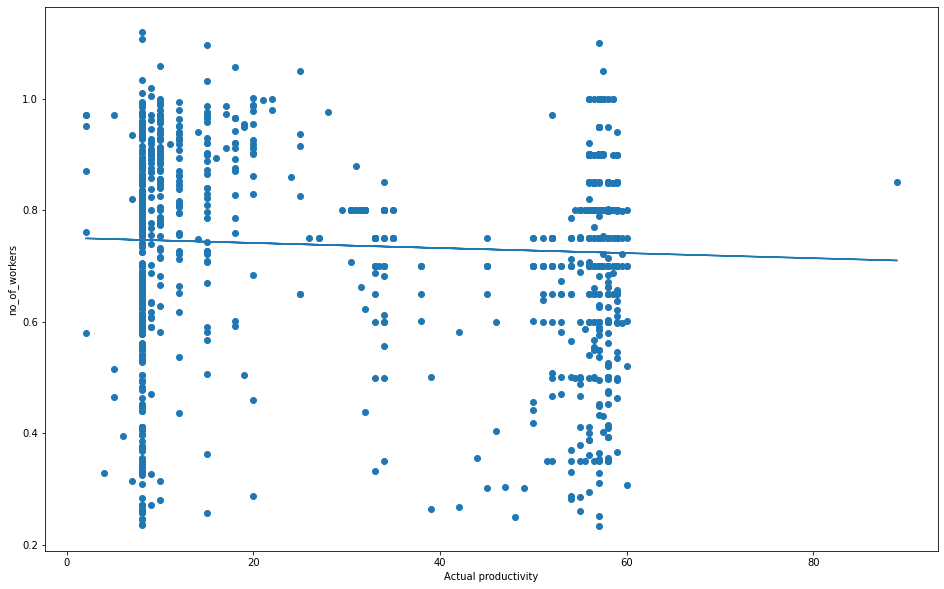

In [1104]:
model = ols("actual_productivity~no_of_workers", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.no_of_workers , b0 + b1*df.no_of_workers)
plt.scatter(df.no_of_workers, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("no_of_workers")

In [1105]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     4.032
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):             0.0449
Time:                         12:51:02   Log-Likelihood:                 393.89
No. Observations:                 1197   AIC:                            -783.8
Df Residuals:                     1195   BIC:                            -773.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7509      0.009 

In [1106]:
fit.pvalues
# The p-value is quite high, so there is a weak correlation between the number of worker and the response variable

Intercept        0.000000
no_of_workers    0.044863
dtype: float64

### quarter - actual productivity

Text(0, 0.5, 'quarter')

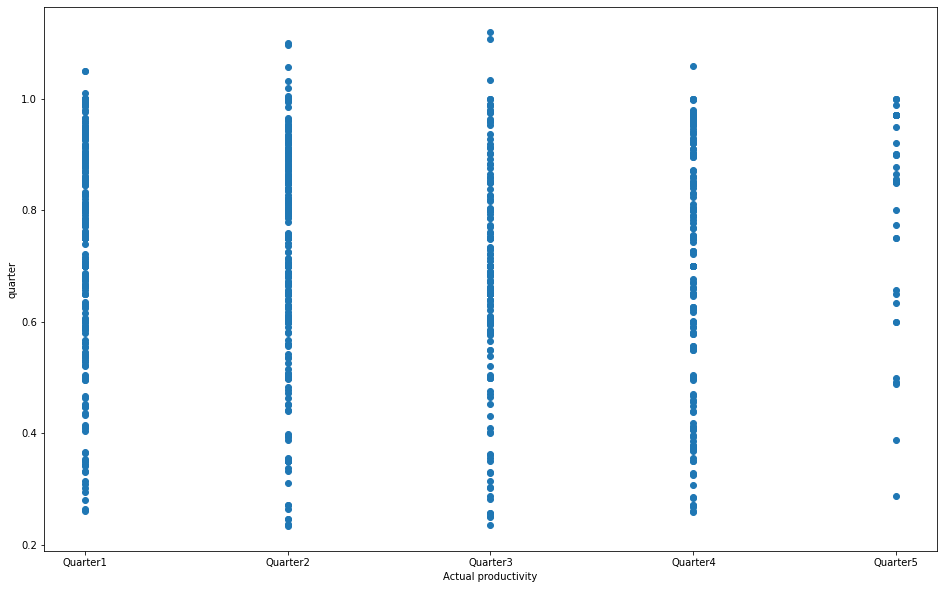

In [1107]:
model = ols("actual_productivity~C(quarter)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.quarter, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("quarter")

In [1108]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.023
Model:                             OLS   Adj. R-squared:                  0.020
Method:                  Least Squares   F-statistic:                     7.112
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           1.17e-05
Time:                         12:51:02   Log-Likelihood:                 405.99
No. Observations:                 1197   AIC:                            -802.0
Df Residuals:                     1192   BIC:                            -776.5
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [1109]:
dir(fit)
fit.pvalues

Intercept                 0.000000
C(quarter)[T.Quarter2]    0.549512
C(quarter)[T.Quarter3]    0.001850
C(quarter)[T.Quarter4]    0.002931
C(quarter)[T.Quarter5]    0.006929
dtype: float64

### department - actual productivity

Text(0, 0.5, 'department')

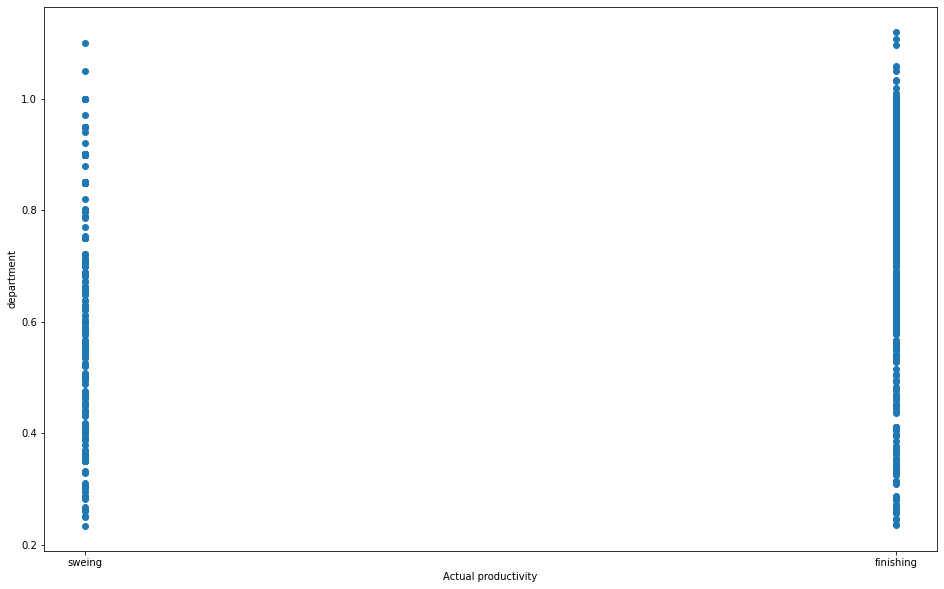

In [1110]:
model = ols("actual_productivity~C(department)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.department, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("department")

In [1111]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     9.246
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):            0.00241
Time:                         12:51:02   Log-Likelihood:                 396.49
No. Observations:                 1197   AIC:                            -789.0
Df Residuals:                     1195   BIC:                            -778.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [1112]:
dir(fit)
fit.pvalues

Intercept                  0.000000
C(department)[T.sweing]    0.002411
dtype: float64

### day - actual productivity

Text(0, 0.5, 'day')

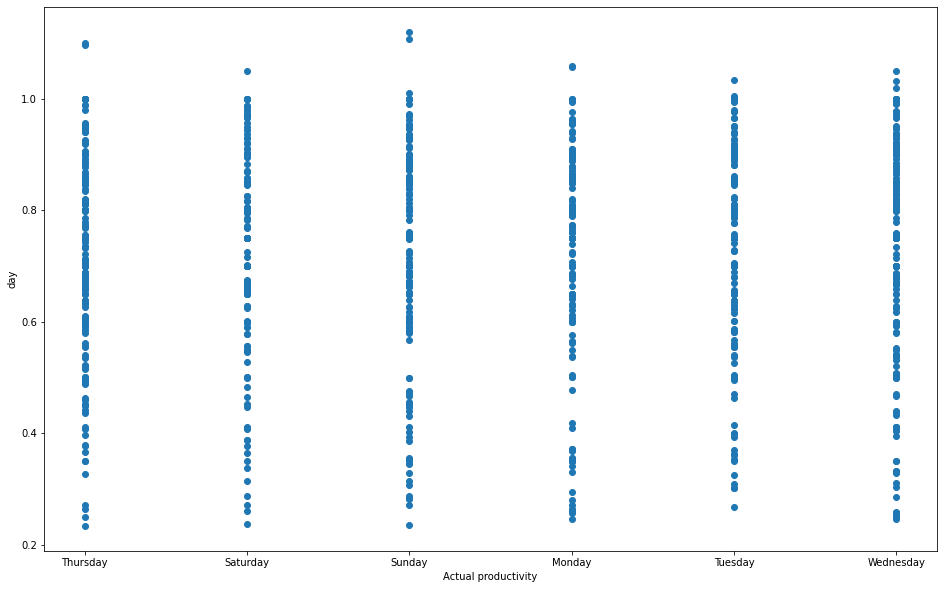

In [1113]:
model = ols("actual_productivity~C(day)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.day, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("day")

In [1114]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.7121
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):              0.614
Time:                         12:51:03   Log-Likelihood:                 393.66
No. Observations:                 1197   AIC:                            -775.3
Df Residuals:                     1191   BIC:                            -744.8
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [1115]:
# All the confidence interval of the days contain zero, and they have all an high p-value, 
# so this means that we cannot reject the null model in favor of the global model.
# This predictor should not be considered.

### team - actual productivity

Text(0, 0.5, 'team')

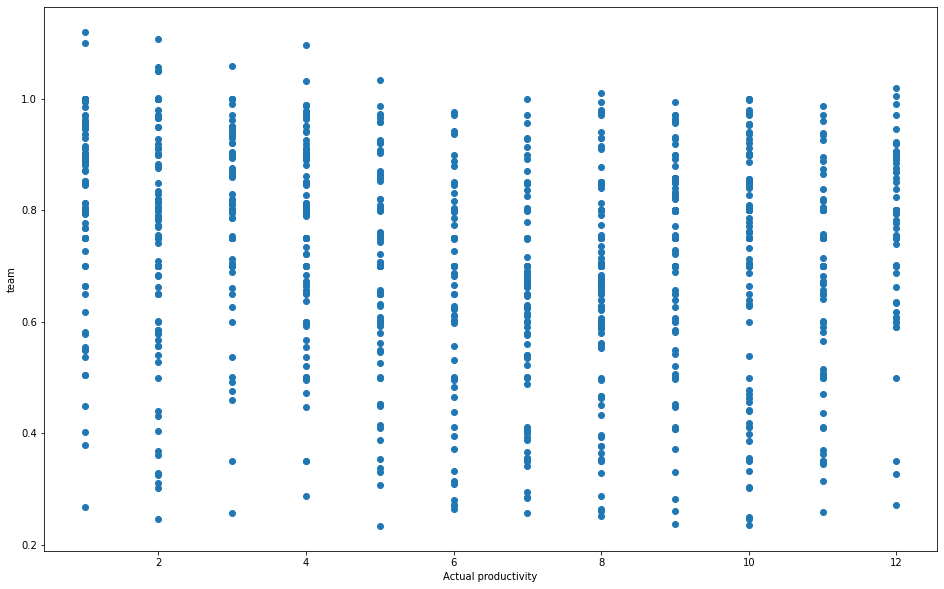

In [1116]:
model = ols("actual_productivity~C(team)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.team, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("team")

In [1117]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.087
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     10.21
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           5.16e-18
Time:                         12:51:03   Log-Likelihood:                 446.09
No. Observations:                 1197   AIC:                            -868.2
Df Residuals:                     1185   BIC:                            -807.1
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8211      0.016 

In [1118]:
fit.pvalues

Intercept        9.708993e-296
C(team)[T.2]      2.862629e-02
C(team)[T.3]      4.692225e-01
C(team)[T.4]      2.753657e-02
C(team)[T.5]      2.908085e-07
C(team)[T.6]      1.484493e-08
C(team)[T.7]      1.436777e-10
C(team)[T.8]      2.060983e-10
C(team)[T.9]      1.958088e-04
C(team)[T.10]     1.630415e-05
C(team)[T.11]     1.176695e-08
C(team)[T.12]     7.378823e-02
dtype: float64

In [1119]:
# Team is responsible for the 8% of the variance, this is a very important predictor.

### Forward selection

In [1120]:
# Only features that have a p-value of at most 0.05 are selected

remaining_features = {'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
                      'no_of_style_change', 'no_of_workers', 'C(quarter)', 'C(department)', 'C(day)', 'C(team)'}
selected_features = []
while remaining_features:
  PF = [] #list of (P value , feature)
  for f in remaining_features:
      temp = selected_features + [f] #temporary list of features
      formula = 'actual_productivity~' + '+'.join(temp)
      fit = ols(formula ,data=df).fit()
      pval= fit.pvalues[-1]
      if pval < 0.05:
        PF.append((pval ,f))
  if PF: #if not empty
      PF.sort(reverse=True)
      (best_pval , best_f) = PF.pop()
      remaining_features.remove(best_f)
      print('feature {} with P-value = {:.2E}'.format(best_f , best_pval))
      selected_features.append(best_f)
  else:
    break

feature targeted_productivity with P-value = 9.00E-53
feature C(day) with P-value = 1.35E-52
feature C(quarter) with P-value = 7.11E-52
feature C(department) with P-value = 5.73E-51
feature C(team) with P-value = 9.90E-47
feature idle_men with P-value = 9.97E-08
feature smv with P-value = 1.10E-07
feature no_of_workers with P-value = 7.80E-09
feature no_of_style_change with P-value = 4.46E-03
feature over_time with P-value = 2.75E-02


### Testing models

#### targeted_productivity + idle_men

In [1121]:
model = ols("actual_productivity~targeted_productivity+idle_men", data=df_train_val) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.199
Model:                             OLS   Adj. R-squared:                  0.197
Method:                  Least Squares   F-statistic:                     103.3
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           8.02e-41
Time:                         12:51:07   Log-Likelihood:                 363.31
No. Observations:                  837   AIC:                            -720.6
Df Residuals:                      834   BIC:                            -706.4
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [1122]:
print(fit.pvalues)
print(fit.aic)

Intercept                1.014706e-06
targeted_productivity    3.860094e-35
idle_men                 2.282758e-08
dtype: float64
-720.614516909505


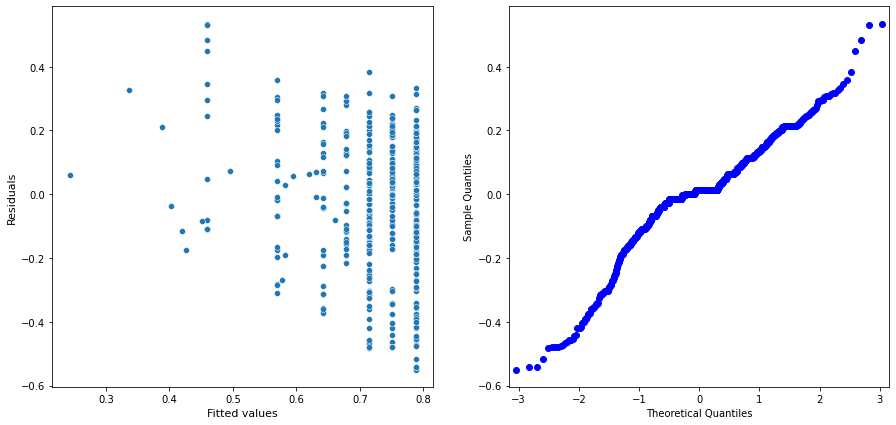

In [1123]:
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 

ax2 = sm.qqplot(fit.resid, ax=ax2)

# The plot between the residuals and the fitted value is not so widely spread as expected

In [1124]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.787684
1134  0.800842   0.787684
1132  0.850427   0.751204
567   0.809236   0.787684
976   0.590617   0.787684
...        ...        ...
617   0.350706   0.333054
1127  0.271875   0.641766
600   1.000230   0.787684
805   0.913750   0.714725
21    0.956271   0.787684

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.110767
R2 0.211512


#### ++ team

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.257
Model:                             OLS   Adj. R-squared:                  0.249
Method:                  Least Squares   F-statistic:                     31.54
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           1.32e-67
Time:                         12:51:07   Log-Likelihood:                 569.99
No. Observations:                 1197   AIC:                            -1112.
Df Residuals:                     1183   BIC:                            -1041.
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

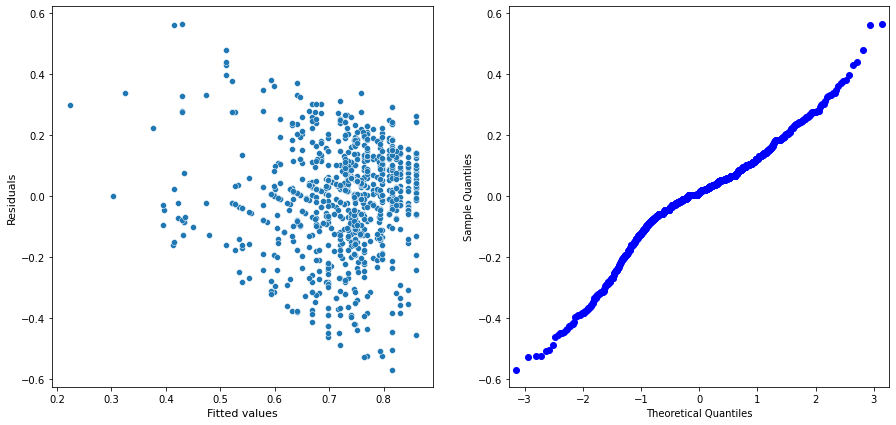

In [1125]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1126]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.768594
1134  0.800842   0.844843
1132  0.850427   0.823413
567   0.809236   0.829414
976   0.590617   0.797280
...        ...        ...
617   0.350706   0.396521
1127  0.271875   0.592425
600   1.000230   0.844843
805   0.913750   0.669040
21    0.956271   0.764056

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.109685
R2 0.246178


In [1127]:
# An increasing of 1 of the targeted_productivity corresponds to an increase of 0.70 of the actual productivity on average

#### ++ department

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.259
Model:                             OLS   Adj. R-squared:                  0.250
Method:                  Least Squares   F-statistic:                     29.54
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           1.90e-67
Time:                         12:51:08   Log-Likelihood:                 571.43
No. Observations:                 1197   AIC:                            -1113.
Df Residuals:                     1182   BIC:                            -1037.
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

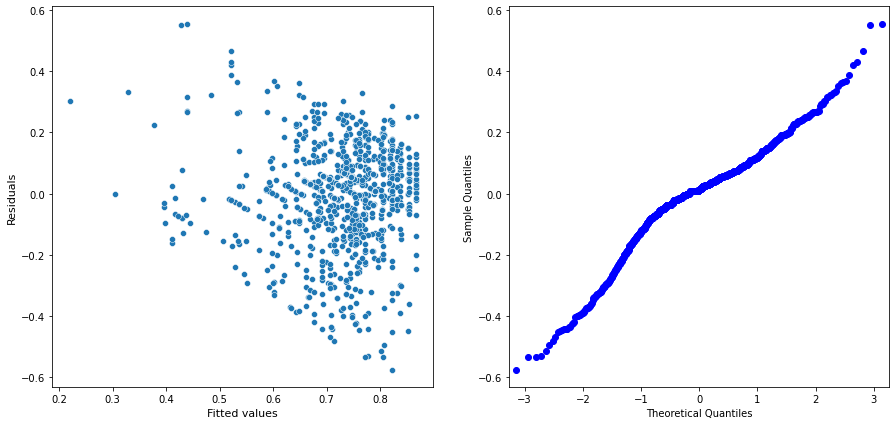

In [1128]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1129]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.761650
1134  0.800842   0.838688
1132  0.850427   0.816351
567   0.809236   0.837475
976   0.590617   0.806156
...        ...        ...
617   0.350706   0.395033
1127  0.271875   0.602525
600   1.000230   0.838688
805   0.913750   0.677426
21    0.956271   0.772279

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.109940
R2 0.247573


#### ++ no_of_style_change

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.268
Model:                             OLS   Adj. R-squared:                  0.259
Method:                  Least Squares   F-statistic:                     28.85
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           1.01e-69
Time:                         12:51:09   Log-Likelihood:                 578.70
No. Observations:                 1197   AIC:                            -1125.
Df Residuals:                     1181   BIC:                            -1044.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

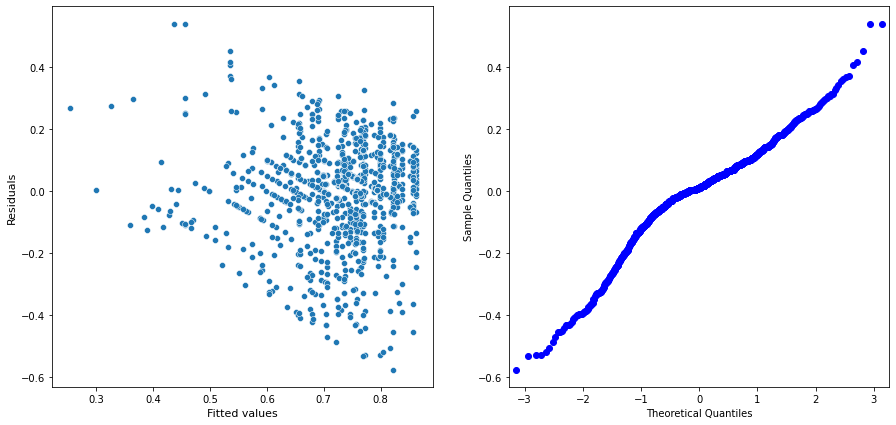

In [1130]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1131]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.768420
1134  0.800842   0.809640
1132  0.850427   0.823502
567   0.809236   0.837367
976   0.590617   0.799138
...        ...        ...
617   0.350706   0.427377
1127  0.271875   0.603443
600   1.000230   0.851988
805   0.913750   0.680047
21    0.956271   0.769614

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.108988
R2 0.257728


#### ++ smv

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.283
Model:                             OLS   Adj. R-squared:                  0.274
Method:                  Least Squares   F-statistic:                     29.16
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           3.37e-74
Time:                         12:51:09   Log-Likelihood:                 591.27
No. Observations:                 1197   AIC:                            -1149.
Df Residuals:                     1180   BIC:                            -1062.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

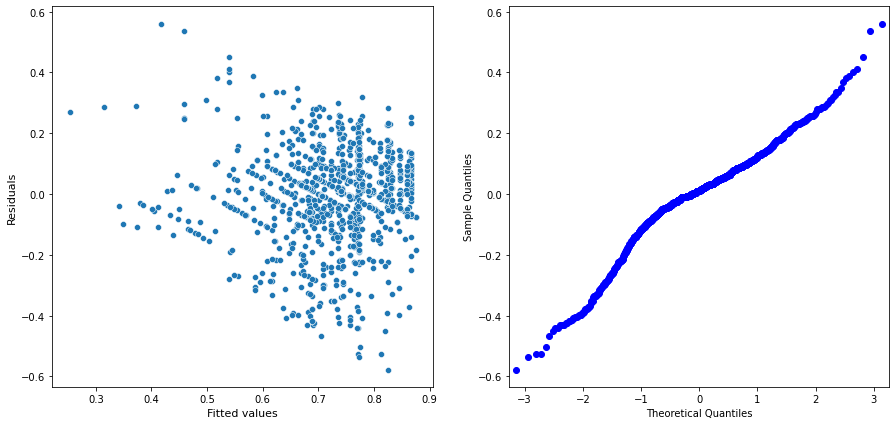

In [1132]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change+smv", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1133]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.771092
1134  0.800842   0.789288
1132  0.850427   0.811882
567   0.809236   0.845283
976   0.590617   0.773118
...        ...        ...
617   0.350706   0.400674
1127  0.271875   0.586785
600   1.000230   0.862329
805   0.913750   0.685494
21    0.956271   0.772017

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.109718
R2 0.256846


In [1134]:
# The standard minute value seems to be important

#### ++ incentive

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.286
Model:                             OLS   Adj. R-squared:                  0.275
Method:                  Least Squares   F-statistic:                     27.73
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           2.90e-74
Time:                         12:51:10   Log-Likelihood:                 593.21
No. Observations:                 1197   AIC:                            -1150.
Df Residuals:                     1179   BIC:                            -1059.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

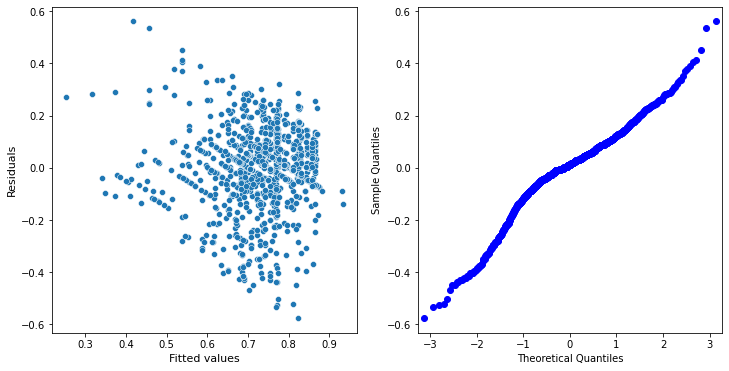

In [1135]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change+smv+incentive", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(12,6))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1136]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.773127
1134  0.800842   0.789457
1132  0.850427   0.812422
567   0.809236   0.843621
976   0.590617   0.771693
...        ...        ...
617   0.350706   0.401038
1127  0.271875   0.586584
600   1.000230   0.864897
805   0.913750   0.685044
21    0.956271   0.769185

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.109578
R2 0.257754


In [1137]:
# incentive has a small coeffiecient,
# however including in the model allows to reach higher R2 values in the training and testing phase.

#### ++ idle_time

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.284
Model:                             OLS   Adj. R-squared:                  0.274
Method:                  Least Squares   F-statistic:                     27.50
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           1.14e-73
Time:                         12:51:10   Log-Likelihood:                 591.77
No. Observations:                 1197   AIC:                            -1148.
Df Residuals:                     1179   BIC:                            -1056.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

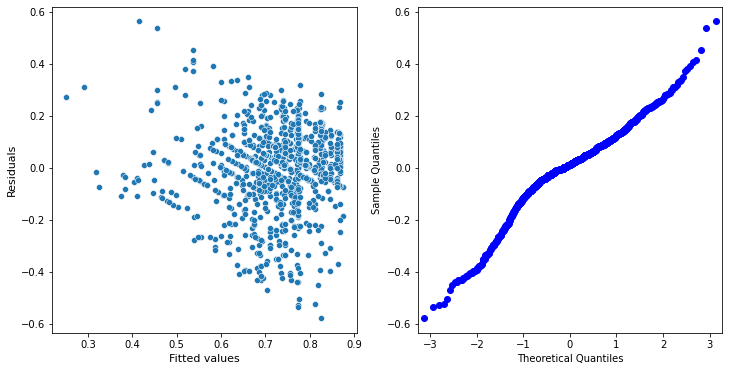

In [1138]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change+smv+idle_time", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(12,6))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1139]:
# idle time has an high p-value, we do not consider it

In [1140]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.771556
1134  0.800842   0.790278
1132  0.850427   0.811667
567   0.809236   0.844923
976   0.590617   0.773290
...        ...        ...
617   0.350706   0.446881
1127  0.271875   0.586499
600   1.000230   0.862033
805   0.913750   0.685445
21    0.956271   0.772130

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.109724
R2 0.256508


#### ++ no_of_workers 

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.302
Model:                             OLS   Adj. R-squared:                  0.292
Method:                  Least Squares   F-statistic:                     30.06
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           3.96e-80
Time:                         12:51:11   Log-Likelihood:                 607.35
No. Observations:                 1197   AIC:                            -1179.
Df Residuals:                     1179   BIC:                            -1087.
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

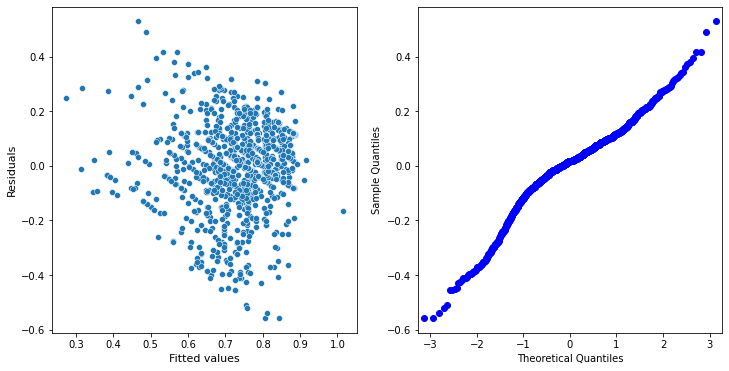

In [1141]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change+smv+no_of_workers", data=df) # define the model
lr = model.fit() #fit the model defined above
print(lr.summary())
print("")
print("############# p-values #############")
print(lr.pvalues)
print("")
print("############# AIC #############")
print(lr.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(12,6))
ax1= sns.scatterplot(data=lr, x=lr.fittedvalues, y=lr.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(lr.resid, ax=ax2)

In [1142]:
y_pred = lr.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.784519
1134  0.800842   0.784260
1132  0.850427   0.826257
567   0.809236   0.837965
976   0.590617   0.808244
...        ...        ...
617   0.350706   0.383949
1127  0.271875   0.624193
600   1.000230   0.873221
805   0.913750   0.675930
21    0.956271   0.756126

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.108181
R2 0.285174


#### ++ quarter

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.316
Model:                             OLS   Adj. R-squared:                  0.303
Method:                  Least Squares   F-statistic:                     25.79
Date:                 Wed, 22 Sep 2021   Prob (F-statistic):           6.68e-82
Time:                         12:51:12   Log-Likelihood:                 618.75
No. Observations:                 1197   AIC:                            -1193.
Df Residuals:                     1175   BIC:                            -1082.
Df Model:                           21                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

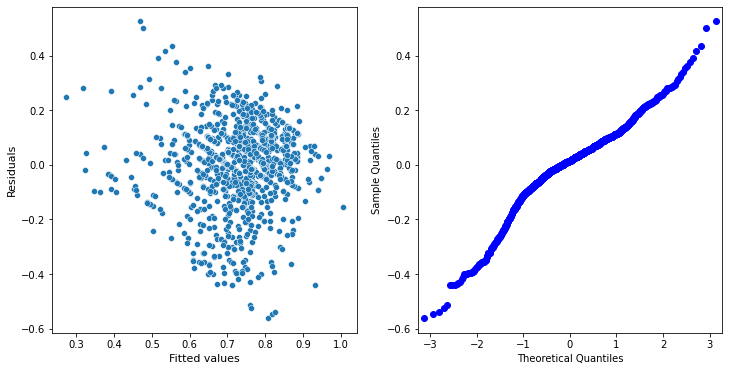

In [1143]:
model = ols("actual_productivity~targeted_productivity+idle_men+C(team)+C(department)+no_of_style_change+smv+no_of_workers+quarter", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print("")
print("############# p-values #############")
print(fit.pvalues)
print("")
print("############# AIC #############")
print(fit.aic)
print("")
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(12,6))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 
ax2 = sm.qqplot(fit.resid, ax=ax2)

In [1144]:
y_pred = fit.predict(X_test)
# Compare predicted and actual values
final_result = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred})
print(final_result)
print("")
print("############# MAE - R2 #############")
print('MAE: %f' % mean_absolute_error(y_test,y_pred)) 
print('R2 %f' % r2_score(y_test,y_pred))

        Actual  Predicted
694   0.900632   0.789263
1134  0.800842   0.794180
1132  0.850427   0.829604
567   0.809236   0.838623
976   0.590617   0.796296
...        ...        ...
617   0.350706   0.383796
1127  0.271875   0.630130
600   1.000230   0.873510
805   0.913750   0.659015
21    0.956271   0.758260

[360 rows x 2 columns]

############# MAE - R2 #############
MAE: 0.106547
R2 0.305037


### Features selection

In [1145]:
X_train_val_sel = X_train_val.loc[:, ['targeted_productivity','idle_men','team', 'department', 'no_of_style_change', 'smv', 'no_of_workers', 'quarter','incentive']]
y_train_val_sel = y_train_val.loc[:, ['actual_productivity']]
X_train_val_sel['team'] = '' + X_train_val_sel['team'].astype(str)
X_train_val_sel = pd.get_dummies(X_train_val_sel, prefix_sep='_')
X_train_val_sel

,targeted_productivity,idle_men,no_of_style_change,smv,no_of_workers,incentive,team_1,team_10,team_11,team_12,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,department_finishing,department_sweing,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5
524,0.75,0,0,3.94,15.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
838,0.70,0,0,5.13,8.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
655,0.80,0,0,22.52,57.5,113,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
136,0.80,0,0,28.08,58.5,63,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
35,0.70,0,0,4.15,8.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.65,0,0,4.15,15.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
752,0.80,0,0,4.08,9.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
406,0.75,0,0,15.26,34.0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
143,0.75,0,0,4.15,12.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [1146]:
X_test_sel = X_test.loc[:, ['targeted_productivity','idle_men','team', 'department', 'no_of_style_change', 'smv', 'no_of_workers', 'quarter', 'incentive']]
y_test_sel = y_test.loc[:, ['actual_productivity']]
X_test_sel['team'] = '' + X_test_sel['team'].astype(str)
X_test_sel = pd.get_dummies(X_test_sel, prefix_sep='_')
X_test_sel

,targeted_productivity,idle_men,no_of_style_change,smv,no_of_workers,incentive,team_1,team_10,team_11,team_12,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,department_finishing,department_sweing,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5
694,0.80,0,0,22.52,56.0,88,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1134,0.80,0,1,30.10,58.0,50,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
1132,0.75,0,0,26.82,59.0,65,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
567,0.80,0,0,4.30,12.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
976,0.80,0,0,4.60,9.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,0.35,15,0,30.10,55.5,23,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
1127,0.60,0,0,2.90,8.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
600,0.80,0,0,22.52,57.0,113,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
805,0.70,0,0,5.13,10.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


### Standardization

In [1147]:
from sklearn.preprocessing import StandardScaler

num_cols = ['targeted_productivity', 'smv', 'incentive', 'idle_men', 'no_of_style_change', 'no_of_workers']
scaler = StandardScaler()
X_train_val_sel[num_cols] = scaler.fit_transform(X_train_val_sel[num_cols])
X_test_sel[num_cols] = scaler.transform(X_test_sel[num_cols])

### Xgboost parameters definition

In [1151]:
dtrain = xgb.DMatrix(X_train_val_sel, label = y_train_val_sel)

params = {"max_depth":3, "eta":0.1}

cross_val = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50)
cross_val

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.268301,0.002682,0.268609,0.005495
1,0.248780,0.002456,0.249720,0.005210
2,0.231675,0.002233,0.233441,0.004918
3,0.216757,0.001960,0.219061,0.004338
4,0.203189,0.001746,0.205843,0.003931
...,...,...,...,...
63,0.103393,0.001067,0.125782,0.004308
64,0.103155,0.001149,0.125669,0.004145
65,0.102986,0.001104,0.125664,0.004138
66,0.102827,0.001023,0.125645,0.004192


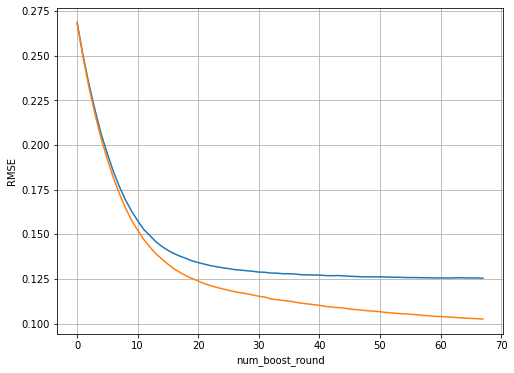

In [1152]:
plt.ﬁgure(ﬁgsize=(8, 6))
plt.plot(cross_val.loc[0:,["test-rmse-mean", "train-rmse-mean"]])
plt.grid()
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')
plt.show()

### Models comparison

In [1153]:
t = PrettyTable()
t.field_names = ['model', 'R2 mean', 'R2 std']
results=[]
pipelines = []
names = []


pipelines.append(('Linear regression', Pipeline([('linear', LinearRegression())])))
pipelines.append(('Ridge', Pipeline([('ridge', Ridge())])))
pipelines.append(('Lasso', Pipeline([('lasso', Lasso())])))
pipelines.append(('Xgboost', Pipeline([('xgboost', 
                                        xgb.XGBRegressor(n_estimators=60,max_depth=3,learning_rate=0.1, objective ='reg:squarederror'))]
                                      )))
pipelines.append(('SVR', Pipeline([('svr', SVR())])))
pipelines.append(('Random forest', Pipeline([('rf', RandomForestRegressor(n_estimators=300))])))


for name, model in pipelines:
  kfold = KFold(n_splits=5, random_state=42, shuffle=True)
  results_kf = []
  kf=0
  print("---------------------------------------------")
  for train_index, test_index in kfold.split(X_train_val_sel, y_train_val_sel):
    kf+=1
    X_train, X_test = X_train_val_sel.values[train_index], X_train_val_sel.values[test_index]
    y_train, y_test = y_train_val_sel.values[train_index], y_train_val_sel.values[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_model = r2_score(y_test, y_pred)
    print(f"R2 {name} - kf{kf} (test set): %.2f" % r2_model)
    results_kf.append(r2_model)
  results.append(results_kf)
  names.append(name)
print("---------------------------------------------")
print("")

for n, r in zip(names, results):
   #print("%s: %f (%f)" % (n, np.mean(r), np.std(r)))
   t.add_row([n, np.mean(r), np.std(r)])
print(t)

---------------------------------------------
R2 Linear regression - kf1 (test set): 0.22
R2 Linear regression - kf2 (test set): 0.26
R2 Linear regression - kf3 (test set): 0.33
R2 Linear regression - kf4 (test set): 0.23
R2 Linear regression - kf5 (test set): 0.31
---------------------------------------------
R2 Ridge - kf1 (test set): 0.22
R2 Ridge - kf2 (test set): 0.26
R2 Ridge - kf3 (test set): 0.33
R2 Ridge - kf4 (test set): 0.23
R2 Ridge - kf5 (test set): 0.31
---------------------------------------------
R2 Lasso - kf1 (test set): -0.01
R2 Lasso - kf2 (test set): -0.06
R2 Lasso - kf3 (test set): -0.01
R2 Lasso - kf4 (test set): -0.00
R2 Lasso - kf5 (test set): -0.00
---------------------------------------------
R2 Xgboost - kf1 (test set): 0.48
R2 Xgboost - kf2 (test set): 0.54
R2 Xgboost - kf3 (test set): 0.54
R2 Xgboost - kf4 (test set): 0.46
R2 Xgboost - kf5 (test set): 0.48
---------------------------------------------
R2 SVR - kf1 (test set): 0.30
R2 SVR - kf2 (test set): 

### Neural Network

In [1154]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible

In [1155]:
X = torch.tensor(X_train_val_sel.values).float()
y = torch.tensor(y_train_val_sel.values).float()
X_t = torch.tensor(X_test_sel.values).float()
y_t = torch.tensor(y_test_sel.values).float()

In [1156]:
# torch can only train on Variable, so convert them to Variable
X, y, X_t, y_t = Variable(X), Variable(y), Variable(X_t), Variable(y_t)

In [1157]:
import torch.nn as nn

class Net(nn.Module):

	def __init__(self):
		super(Net, self).__init__()

		self.layer1 = torch.nn.Linear(25, 30)
		self.layer2 = torch.nn.Linear(30, 15)
		self.layer3 = torch.nn.Linear(15, 1)
		self.leaky_relu = nn.LeakyReLU()

	def forward(self, x):
		x = self.layer1(x)
		x = self.leaky_relu(x)
		x = self.layer2(x)
		x = self.leaky_relu(x)
		x = self.layer3(x)

		return x

In [1163]:
net = Net()

optimizer = torch.optim.Adam(net.parameters())
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 150
EPOCH = 301

torch_dataset = Data.TensorDataset(X, y)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

In [1166]:
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)


        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        optimizer.zero_grad()   # clear gradients for next train
    
    if epoch % 10 == 0:
      print('iter = {0:8d}/{1:8d}, loss = {2:.3f}'.format(epoch, EPOCH-1, loss))

y_pred = net(X_t)
r2_model = r2_score(y_t.numpy(), y_pred.detach().numpy())
print("")
print("---------------------------------------------")
print("")
print(f"R2 Neural network: %.2f" % r2_model)

iter =        0/     300, loss = 0.009
iter =       10/     300, loss = 0.009
iter =       20/     300, loss = 0.008
iter =       30/     300, loss = 0.007
iter =       40/     300, loss = 0.015
iter =       50/     300, loss = 0.011
iter =       60/     300, loss = 0.012
iter =       70/     300, loss = 0.006
iter =       80/     300, loss = 0.012
iter =       90/     300, loss = 0.009
iter =      100/     300, loss = 0.011
iter =      110/     300, loss = 0.009
iter =      120/     300, loss = 0.007
iter =      130/     300, loss = 0.010
iter =      140/     300, loss = 0.010
iter =      150/     300, loss = 0.006
iter =      160/     300, loss = 0.008
iter =      170/     300, loss = 0.009
iter =      180/     300, loss = 0.007
iter =      190/     300, loss = 0.006
iter =      200/     300, loss = 0.008
iter =      210/     300, loss = 0.009
iter =      220/     300, loss = 0.004
iter =      230/     300, loss = 0.012
iter =      240/     300, loss = 0.008
iter =      250/     300,

In [ ]:
# The best performance has been achieved by the Xgboost model, followed by the random forest regressor. 
# A fully connected neural network in this scenario is not providing a better performance with the respect 
# to the other tested machine learning algorithms.